In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import st_dep as st
import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'relative'
model_name = 'rnn'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = generic.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

In [13]:
emb_dim = 100
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6741057771423552 	 Validation loss: 0.6511574094578371 	 
  1%|          | 574/57400 [00:10<15:51, 59.69it/s]
Epoch 2 	 Training loss: 0.6186721620867062 	 Validation loss: 0.5992089121018426 	 
  2%|▏         | 1148/57400 [00:19<14:52, 63.06it/s]
Epoch 3 	 Training loss: 0.5761934565542467 	 Validation loss: 0.5661170851376097 	 
  3%|▎         | 1722/57400 [00:29<15:14, 60.89it/s]
Epoch 4 	 Training loss: 0.5470556040466454 	 Validation loss: 0.5442124564768904 	 
  4%|▍         | 2296/57400 [00:38<14:21, 63.99it/s]
Epoch 5 	 Training loss: 0.5234608387490183 	 Validation loss: 0.529495670633801 	 
  5%|▌         | 2870/57400 [00:48<14:22, 63.20it/s]
Epoch 6 	 Training loss: 0.5036091660684825 	 Validation loss: 0.5135083249059774 	 
  6%|▌         | 3444/57400 [00:58<14:40, 61.27it/s]
Epoch 7 	 Training loss: 0.4869794254207445 	 Validation loss: 0.501566618680954 	 
  7%|▋         | 4018/57400 [01:07<13:50, 64.25it/s]
Epoch 8 	 Training loss: 0.4718740643

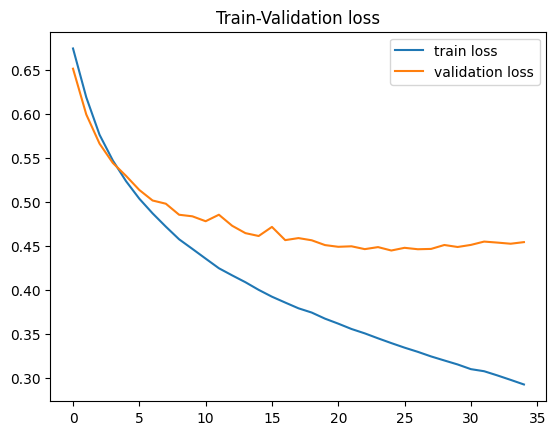

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.5775, 'male': 0.8515625, 'average': 0.7145312500000001}
precision {'female': 0.8020833333333334, 'male': 0.6592741935483871, 'average': 0.7306787634408602}
f1 {'female': 0.6715116279069768, 'male': 0.7431818181818182, 'average': 0.7073467230443975}
accuracy 0.7117346938775511


Evaluación en el conjunto el conjunto to
recall {'female': 0.4120734908136483, 'male': 0.7201946472019465, 'average': 0.5661340690077974}
precision {'female': 0.5772058823529411, 'male': 0.5692307692307692, 'average': 0.5732183257918552}
f1 {'female': 0.4808575803981623, 'male': 0.635875402792696, 'average': 0.5583664915954292}
accuracy 0.571969696969697


Evaluación en el conjunto el conjunto as
recall {'female': 0.4555256064690027, 'male': 0.7575757575757576, 'average': 0.6065506820223802}
precision {'female': 0.6377358490566037, 'male': 0.5976095617529881, 'average': 0.6176727054047959}
f1 {'female': 0.5314465408805032, 'male': 0.66815144766146

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.676703826371801 	 Validation loss: 0.6653169090464964 	 
  1%|          | 574/57400 [00:09<15:37, 60.61it/s]
Epoch 2 	 Training loss: 0.6297259147989626 	 Validation loss: 0.6116774546898017 	 
  2%|▏         | 1148/57400 [00:19<14:50, 63.16it/s]
Epoch 3 	 Training loss: 0.5861251292951432 	 Validation loss: 0.5807940015348337 	 
  3%|▎         | 1722/57400 [00:28<14:59, 61.87it/s]
Epoch 4 	 Training loss: 0.5559571805419822 	 Validation loss: 0.5619529187679291 	 
  4%|▍         | 2296/57400 [00:38<14:43, 62.39it/s]
Epoch 5 	 Training loss: 0.5324394501979343 	 Validation loss: 0.5469971970986511 	 
  5%|▌         | 2870/57400 [00:48<14:18, 63.50it/s]
Epoch 6 	 Training loss: 0.51164776548899 	 Validation loss: 0.5305005640296613 	 
  6%|▌         | 3444/57400 [00:57<14:08, 63.57it/s]
Epoch 7 	 Training loss: 0.4933846772028594 	 Validation loss: 0.5184347200191627 	 
  7%|▋         | 4018/57400 [01:07<14:03, 63.28it/s]
Epoch 8 	 Training loss: 0.47883913310

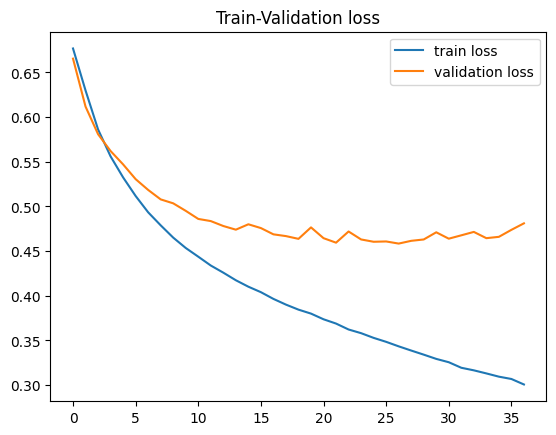

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.665, 'male': 0.8203125, 'average': 0.74265625}
precision {'female': 0.7940298507462686, 'male': 0.7015590200445434, 'average': 0.747794435395406}
f1 {'female': 0.7238095238095238, 'male': 0.7563025210084033, 'average': 0.7400560224089636}
accuracy 0.7410714285714286


Evaluación en el conjunto el conjunto to
recall {'female': 0.5144356955380578, 'male': 0.6885644768856448, 'average': 0.6015000862118514}
precision {'female': 0.6049382716049383, 'male': 0.6047008547008547, 'average': 0.6048195631528965}
f1 {'female': 0.5560283687943263, 'male': 0.6439135381114903, 'average': 0.5999709534529083}
accuracy 0.6047979797979798


Evaluación en el conjunto el conjunto as
recall {'female': 0.5956873315363881, 'male': 0.6590909090909091, 'average': 0.6273891203136486}
precision {'female': 0.6207865168539326, 'male': 0.635036496350365, 'average': 0.6279115066021488}
f1 {'female': 0.607977991746905, 'male': 0.6468401486988847, 'avera

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6755767666088994 	 Validation loss: 0.6606316990771536 	 
  1%|          | 574/57400 [00:09<15:37, 60.63it/s]
Epoch 2 	 Training loss: 0.6187868555456089 	 Validation loss: 0.5953105304200771 	 
  2%|▏         | 1148/57400 [00:19<15:20, 61.13it/s]
Epoch 3 	 Training loss: 0.574928555754419 	 Validation loss: 0.5681817910428775 	 
  3%|▎         | 1722/57400 [00:29<14:41, 63.16it/s]
Epoch 4 	 Training loss: 0.5473299965210493 	 Validation loss: 0.5487214533959405 	 
  4%|▍         | 2296/57400 [00:38<15:21, 59.82it/s]
Epoch 5 	 Training loss: 0.5246497113322547 	 Validation loss: 0.5336129786604542 	 
  5%|▌         | 2870/57400 [00:48<13:49, 65.75it/s]
Epoch 6 	 Training loss: 0.5058629536151055 	 Validation loss: 0.5163008009983321 	 
  6%|▌         | 3444/57400 [00:57<14:58, 60.07it/s]
Epoch 7 	 Training loss: 0.4889283338594104 	 Validation loss: 0.5086804294990281 	 
  7%|▋         | 4018/57400 [01:07<14:27, 61.52it/s]
Epoch 8 	 Training loss: 0.474118297

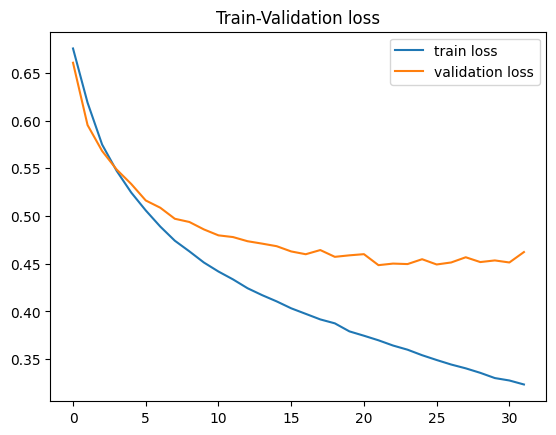

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.63, 'male': 0.8255208333333334, 'average': 0.7277604166666667}
precision {'female': 0.7899686520376176, 'male': 0.6817204301075269, 'average': 0.7358445410725722}
f1 {'female': 0.7009735744089013, 'male': 0.7467608951707891, 'average': 0.7238672347898452}
accuracy 0.7257653061224489


Evaluación en el conjunto el conjunto to
recall {'female': 0.46194225721784776, 'male': 0.6690997566909975, 'average': 0.5655210069544226}
precision {'female': 0.5641025641025641, 'male': 0.5729166666666666, 'average': 0.5685096153846154}
f1 {'female': 0.5079365079365079, 'male': 0.6172839506172839, 'average': 0.562610229276896}
accuracy 0.5694444444444444


Evaluación en el conjunto el conjunto as
recall {'female': 0.5283018867924528, 'male': 0.6843434343434344, 'average': 0.6063226605679436}
precision {'female': 0.6105919003115264, 'male': 0.6076233183856502, 'average': 0.6091076093485883}
f1 {'female': 0.5664739884393063, 'male': 0.64370

In [21]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.7237566600810688
f1 etiqueta male: 0.7487484114536702
f1 etiqueta female:  0.6987649087084673


TO
Resultado global f1: 0.5736492247750778
f1 etiqueta male: 0.6323576305071568
f1 etiqueta female:  0.5149408190429988


AS
Resultado global f1: 0.6107659301016612
f1 etiqueta male: 0.6528990198477508
f1 etiqueta female:  0.5686328403555715


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.7283159722222222
recall etiqueta male: 0.8324652777777778
recall etiqueta female:  0.6241666666666666


TO
Resultado global recall: 0.5777183873913572
recall etiqueta male: 0.6926196269261963
recall etiqueta female:  0.46281714785651795


AS
Resultado global recall: 0.6134208209679908
recall etiqueta male: 0.7003367003367004
recall etiqueta female:  0.5265049415992812


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.7381059133029462
precision etiqueta male: 0.6808512145668192
precision etiqueta female:  0.

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935434620762536 	 Validation loss: 0.6924871226488534 	 
  1%|          | 574/57400 [00:09<15:43, 60.21it/s]
Epoch 2 	 Training loss: 0.6935488933677872 	 Validation loss: 0.6927141789662636 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:44, 59.54it/s]
Epoch 3 	 Training loss: 0.6933090700297405 	 Validation loss: 0.6925375310041136 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:05, 61.48it/s]
Epoch 4 	 Training loss: 0.6930789254891332 	 Validation loss: 0.6926622774641392 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<14:55, 61.55it/s]
Epoch 5 	 Training loss: 0.6929406129109319 	 Validation loss: 0.692433779522524 	 
  5%|▌         | 2870/57400 [00:49<14:29, 62.75it/s]
Epoch 6 	 Training loss: 0.693005927452227 	 Validation loss: 0.6927556324813325 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:55, 60.24it/s]
Epoch 7 	 Training loss: 0.6929547421192873 	 Validation lo

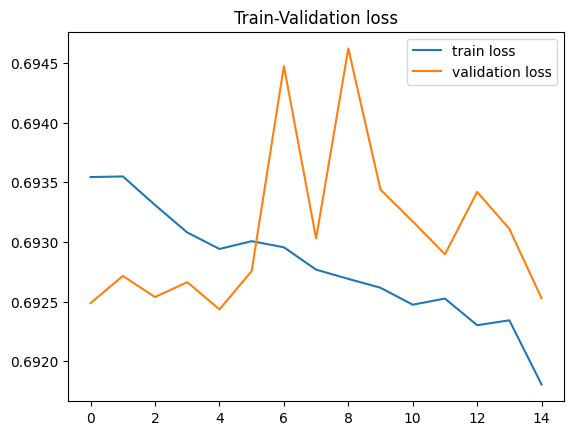

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.8275, 'male': 0.1796875, 'average': 0.5035937500000001}
precision {'female': 0.5123839009287926, 'male': 0.5, 'average': 0.5061919504643964}
f1 {'female': 0.6328871892925431, 'male': 0.26436781609195403, 'average': 0.44862750269224855}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to
recall {'female': 0.8582677165354331, 'male': 0.17274939172749393, 'average': 0.5155085541314635}
precision {'female': 0.49025487256371814, 'male': 0.568, 'average': 0.529127436281859}
f1 {'female': 0.6240458015267175, 'male': 0.26492537313432835, 'average': 0.4444855873305229}
accuracy 0.5025252525252525


Evaluación en el conjunto el conjunto as
recall {'female': 0.8598382749326146, 'male': 0.1388888888888889, 'average': 0.4993635819107517}
precision {'female': 0.48333333333333334, 'male': 0.514018691588785, 'average': 0.4986760124610592}
f1 {'female': 0.6188166828322017, 'male': 0.21868787276341947, 'average': 0.4187

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938472744272146 	 Validation loss: 0.6940019120604305 	 
  1%|          | 574/57400 [00:09<15:49, 59.87it/s]
Epoch 2 	 Training loss: 0.6934413338787464 	 Validation loss: 0.6948044805203454 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<14:50, 63.16it/s]
Epoch 3 	 Training loss: 0.69309537252898 	 Validation loss: 0.696608477729862 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<15:11, 61.09it/s]
Epoch 4 	 Training loss: 0.69313275149475 	 Validation loss: 0.6936919446718894 	 
  4%|▍         | 2296/57400 [00:39<14:44, 62.31it/s]
Epoch 5 	 Training loss: 0.6929000139444131 	 Validation loss: 0.6958108089737973 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:48<15:01, 60.50it/s]
Epoch 6 	 Training loss: 0.6929967692089413 	 Validation loss: 0.6963978308742329 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:58<14:40, 61.27it/s]
Epoch 7 	 Training loss: 0.6929659764525782 	 Validation loss:

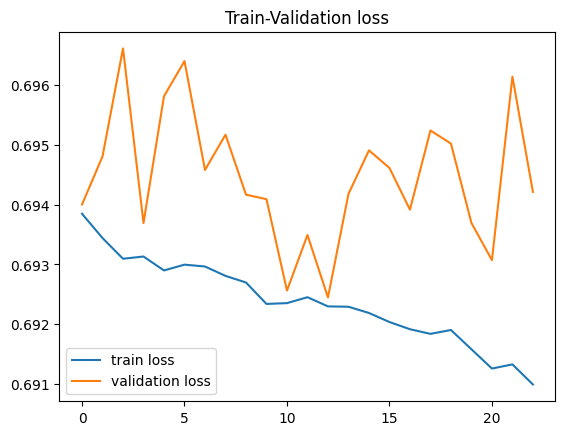

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.91, 'male': 0.059895833333333336, 'average': 0.4849479166666667}
precision {'female': 0.5020689655172413, 'male': 0.3898305084745763, 'average': 0.4459497369959088}
f1 {'female': 0.6471111111111111, 'male': 0.10383747178329572, 'average': 0.3754742914472034}
accuracy 0.49362244897959184


Evaluación en el conjunto el conjunto to
recall {'female': 0.94750656167979, 'male': 0.06569343065693431, 'average': 0.5065999961683622}
precision {'female': 0.48456375838926175, 'male': 0.574468085106383, 'average': 0.5295159217478224}
f1 {'female': 0.6412078152753109, 'male': 0.11790393013100438, 'average': 0.37955587270315766}
accuracy 0.4898989898989899


Evaluación en el conjunto el conjunto as
recall {'female': 0.967654986522911, 'male': 0.06313131313131314, 'average': 0.515393149827112}
precision {'female': 0.4917808219178082, 'male': 0.6756756756756757, 'average': 0.5837282487967419}
f1 {'female': 0.6521344232515894, 'male': 0.1

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936262677770874 	 Validation loss: 0.6928749528981871 	 
  1%|          | 574/57400 [00:10<15:48, 59.92it/s]
Epoch 2 	 Training loss: 0.6934183384275603 	 Validation loss: 0.693179302296396 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:33, 60.28it/s]
Epoch 3 	 Training loss: 0.6932746918566967 	 Validation loss: 0.6933722687979876 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<15:23, 60.29it/s]
Epoch 4 	 Training loss: 0.6933648771109897 	 Validation loss: 0.6932185100296796 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:39<14:45, 62.22it/s]
Epoch 5 	 Training loss: 0.6929105657318327 	 Validation loss: 0.6932688678725291 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:49<14:27, 62.84it/s]
Epoch 6 	 Training loss: 0.6929752579549464 	 Validation loss: 0.691810713986219 	 
  6%|▌         | 3444/57400 [00:59<14:52, 60.46it/s]
Epoch 7 	 Training loss: 0.6929882506252582 	 Validation lo

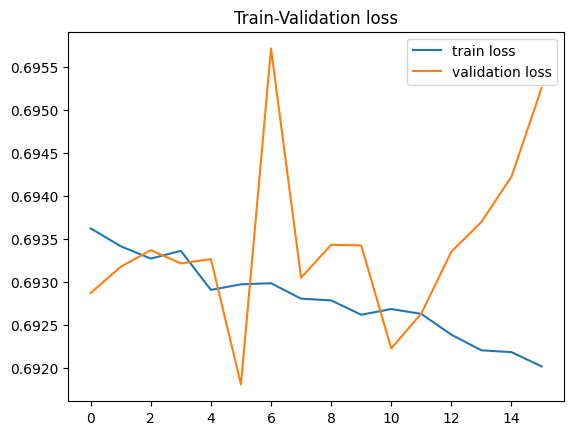

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.97, 'male': 0.026041666666666668, 'average': 0.4980208333333333}
precision {'female': 0.5091863517060368, 'male': 0.45454545454545453, 'average': 0.4818659031257456}
f1 {'female': 0.6678141135972462, 'male': 0.04926108374384237, 'average': 0.3585375986705443}
accuracy 0.5076530612244898


Evaluación en el conjunto el conjunto to
recall {'female': 0.9763779527559056, 'male': 0.024330900243309004, 'average': 0.5003544264996073}
precision {'female': 0.48124191461837, 'male': 0.5263157894736842, 'average': 0.5037788520460271}
f1 {'female': 0.6447140381282496, 'male': 0.04651162790697675, 'average': 0.34561283301761314}
accuracy 0.4823232323232323


Evaluación en el conjunto el conjunto as
recall {'female': 0.9838274932614556, 'male': 0.022727272727272728, 'average': 0.5032773829943642}
precision {'female': 0.4853723404255319, 'male': 0.6, 'average': 0.5426861702127659}
f1 {'female': 0.6500445235975066, 'male': 0.043795620437

In [29]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.39421313093666543
f1 etiqueta male: 0.13915545720636405
f1 etiqueta female:  0.6492708046669667


TO
Resultado global f1: 0.38988476435043123
f1 etiqueta male: 0.14311364372410315
f1 etiqueta female:  0.6366558849767593


AS
Resultado global f1: 0.3831587606652031
f1 etiqueta male: 0.12598564476997356
f1 etiqueta female:  0.6403318765604326


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.49552083333333335
recall etiqueta male: 0.08854166666666667
recall etiqueta female:  0.9025


TO
Resultado global recall: 0.5074876589331443
recall etiqueta male: 0.08759124087591241
recall etiqueta female:  0.9273840769903762


AS
Resultado global recall: 0.5060113715774093
recall etiqueta male: 0.07491582491582492
recall etiqueta female:  0.9371069182389937


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4780025301953503
precision etiqueta male: 0.44812532100667696
precision etiqueta female:  0.507

## AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937254819928146 	 Validation loss: 0.6935168939121699 	 
  1%|          | 574/57400 [00:09<15:12, 62.24it/s]
Epoch 2 	 Training loss: 0.6931485939731996 	 Validation loss: 0.6949376241635468 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<15:20, 61.13it/s]
Epoch 3 	 Training loss: 0.6932476872143429 	 Validation loss: 0.6939301510988656 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<15:21, 60.40it/s]
Epoch 4 	 Training loss: 0.6927832629830164 	 Validation loss: 0.6924061785310002 	 
  4%|▍         | 2296/57400 [00:39<15:11, 60.44it/s]
Epoch 5 	 Training loss: 0.6927230414197836 	 Validation loss: 0.6921890681072816 	 
  5%|▌         | 2870/57400 [00:48<15:15, 59.54it/s]
Epoch 6 	 Training loss: 0.6925901439339441 	 Validation loss: 0.692663839307882 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:58<14:35, 61.60it/s]
Epoch 7 	 Training loss: 0.6921385513157795 	 Validation loss: 0.6933666386846769 	 

2

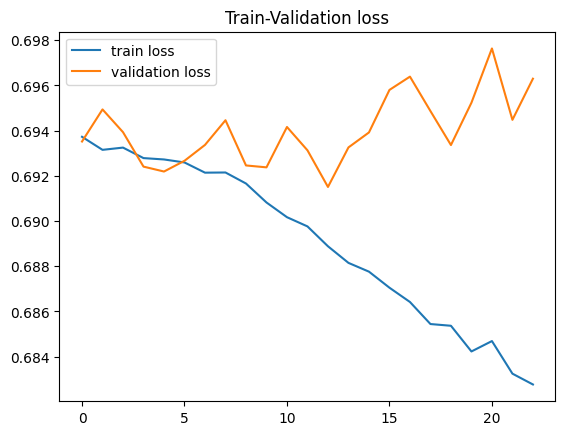

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.4025, 'male': 0.5651041666666666, 'average': 0.4838020833333333}
precision {'female': 0.49085365853658536, 'male': 0.4758771929824561, 'average': 0.48336542575952074}
f1 {'female': 0.44230769230769235, 'male': 0.5166666666666666, 'average': 0.47948717948717945}
accuracy 0.48214285714285715


Evaluación en el conjunto el conjunto to
recall {'female': 0.38320209973753283, 'male': 0.6739659367396593, 'average': 0.5285840182385961}
precision {'female': 0.5214285714285715, 'male': 0.541015625, 'average': 0.5312220982142857}
f1 {'female': 0.4417549167927383, 'male': 0.6002166847237269, 'average': 0.5209858007582326}
accuracy 0.5340909090909091


Evaluación en el conjunto el conjunto as
recall {'female': 0.4716981132075472, 'male': 0.6212121212121212, 'average': 0.5464551172098342}
precision {'female': 0.5384615384615384, 'male': 0.5565610859728507, 'average': 0.5475113122171946}
f1 {'female': 0.5028735632183908, 'male': 0.5871

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937293313729223 	 Validation loss: 0.6912594063807342 	 
  1%|          | 574/57400 [00:10<17:47, 53.22it/s]
Epoch 2 	 Training loss: 0.69336401647807 	 Validation loss: 0.6946518603017775 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:19<15:34, 60.20it/s]
Epoch 3 	 Training loss: 0.6932442913072034 	 Validation loss: 0.6939240108102055 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:29<15:17, 60.69it/s]
Epoch 4 	 Training loss: 0.692933874470847 	 Validation loss: 0.6947396963329638 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:32, 59.07it/s]
Epoch 5 	 Training loss: 0.6926760918587342 	 Validation loss: 0.6928389971539125 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:50<15:12, 59.74it/s]
Epoch 6 	 Training loss: 0.6926726087252852 	 Validation loss: 0.6921583727254705 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:59<14:55, 60.28it/s]
Epoch 7 	 Training loss: 0.6926

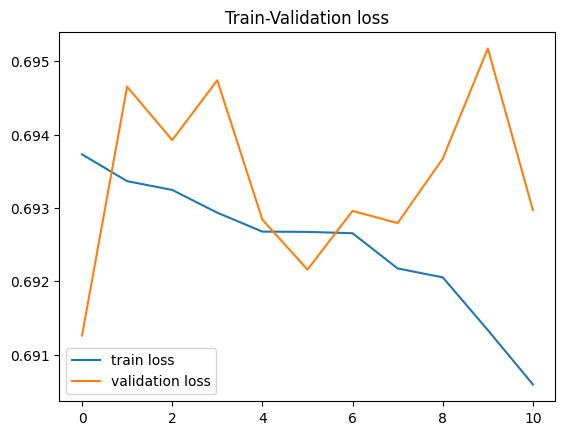

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.9375, 'male': 0.059895833333333336, 'average': 0.4986979166666667}
precision {'female': 0.5095108695652174, 'male': 0.4791666666666667, 'average': 0.494338768115942}
f1 {'female': 0.6602112676056339, 'male': 0.1064814814814815, 'average': 0.3833463745435577}
accuracy 0.5076530612244898


Evaluación en el conjunto el conjunto to
recall {'female': 0.9396325459317585, 'male': 0.08029197080291971, 'average': 0.5099622583673391}
precision {'female': 0.48641304347826086, 'male': 0.5892857142857143, 'average': 0.5378493788819876}
f1 {'female': 0.6410026857654432, 'male': 0.14132762312633831, 'average': 0.39116515444589073}
accuracy 0.4936868686868687


Evaluación en el conjunto el conjunto as
recall {'female': 0.9568733153638814, 'male': 0.05555555555555555, 'average': 0.5062144354597184}
precision {'female': 0.4869684499314129, 'male': 0.5789473684210527, 'average': 0.5329579091762328}
f1 {'female': 0.6454545454545455, 'male':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6938189916079053 	 Validation loss: 0.696889453015085 	 
  1%|          | 574/57400 [00:09<15:08, 62.53it/s]
Epoch 2 	 Training loss: 0.6933825669180641 	 Validation loss: 0.6922860125363883 	 
  2%|▏         | 1148/57400 [00:19<15:24, 60.86it/s]
Epoch 3 	 Training loss: 0.6930557853876506 	 Validation loss: 0.6915967717009076 	 
  3%|▎         | 1722/57400 [00:29<14:52, 62.39it/s]
Epoch 4 	 Training loss: 0.6929477795906599 	 Validation loss: 0.6940693966412949 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:39<15:18, 60.00it/s]
Epoch 5 	 Training loss: 0.6928365497431274 	 Validation loss: 0.6940892035678282 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:49<15:03, 60.37it/s]
Epoch 6 	 Training loss: 0.6925208992243644 	 Validation loss: 0.6919408258745225 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:58<14:27, 62.17it/s]
Epoch 7 	 Training loss: 0.6923359599262995 	 Validation loss: 0.6944009631367053 	 

4

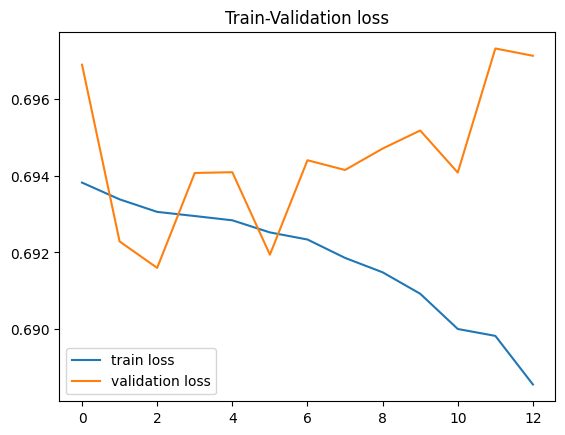

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.9075, 'male': 0.09375, 'average': 0.500625}
precision {'female': 0.510548523206751, 'male': 0.4931506849315068, 'average': 0.5018496040691289}
f1 {'female': 0.6534653465346535, 'male': 0.1575492341356674, 'average': 0.4055072903351604}
accuracy 0.5089285714285714


Evaluación en el conjunto el conjunto to
recall {'female': 0.884514435695538, 'male': 0.0948905109489051, 'average': 0.48970247332222155}
precision {'female': 0.47531734837799716, 'male': 0.46987951807228917, 'average': 0.47259843322514317}
f1 {'female': 0.618348623853211, 'male': 0.15789473684210525, 'average': 0.38812168034765815}
accuracy 0.47474747474747475


Evaluación en el conjunto el conjunto as
recall {'female': 0.9164420485175202, 'male': 0.10606060606060606, 'average': 0.5112513272890631}
precision {'female': 0.4899135446685879, 'male': 0.5753424657534246, 'average': 0.5326280052110063}
f1 {'female': 0.6384976525821596, 'male': 0.17910447761194032, 

In [37]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.42278028145529917
f1 etiqueta male: 0.2602324607612718
f1 etiqueta female:  0.5853281021493266


TO
Resultado global f1: 0.4334242118505938
f1 etiqueta male: 0.29981301489739015
f1 etiqueta female:  0.5670354088037974


AS
Resultado global f1: 0.4424041498640013
f1 etiqueta male: 0.2891997126429706
f1 etiqueta female:  0.595608587085032


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.494375
recall etiqueta male: 0.23958333333333331
recall etiqueta female:  0.7491666666666666


TO
Resultado global recall: 0.5094162499760523
recall etiqueta male: 0.2830494728304947
recall etiqueta female:  0.7357830271216098


AS
Resultado global recall: 0.5213069599862052
recall etiqueta male: 0.2609427609427609
recall etiqueta female:  0.7816711590296496


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4931845993148639
precision etiqueta male: 0.4827315148602099
precision etiqueta female:  0.503637683